In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import multilabel_confusion_matrix,accuracy_score
from scipy import stats

In [3]:
mp_holistic=mp.solutions.holistic
mp_drawing=mp.solutions.drawing_utils

In [2]:
def mediapipe_detection(image,model):
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image.flags.writeable=False
    results=model.process(image)
    image.flags.writeable=True
    image=cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    return image,results

In [4]:
def draw_landmarks(image,results):
    mp_drawing.draw_landmarks(image,results.face_landmarks,mp_holistic.FACEMESH_TESSELATION)
    mp_drawing.draw_landmarks(image,results.pose_landmarks,mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image,results.left_hand_landmarks,mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image,results.right_hand_landmarks,mp_holistic.HAND_CONNECTIONS)

In [5]:
def draw_styled_landmarks(image,results):
    mp_drawing.draw_landmarks(image,results.face_landmarks,mp_holistic.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color=(80,110,10),thickness=1,circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,255,120),thickness=1,circle_radius=1))
    
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,120), thickness=2, circle_radius=2)) 

    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)) 

    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)) 

In [6]:
cap=cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret,frame=cap.read()
        image,results=mediapipe_detection(frame,holistic)
        draw_styled_landmarks(image,results)
        cv2.imshow("Frame",image)
        if cv2.waitKey(1) & 0xFF==ord("q"):
            break
    cap.release()
    cv2.destroyAllWindows()

C:\Users\Likhith Chakravarthi\anaconda3\lib\site-packages\google\protobuf\symbol_database.py:78: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [93]:
cap.release()

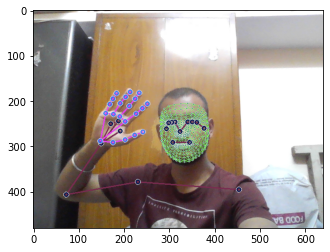

In [94]:
draw_styled_landmarks(frame, results)
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [57]:
len(results.left_hand_landmarks.landmark)

21

In [46]:
pose=[]
for res in results.right_hand_landmarks.landmark:
    test=np.array([res.x,res.y,res.z,res.visibility])
    pose.append(test)

In [47]:
pose=np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face=np.array([[res.x,res.y,res.z] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(1404)
lh=np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh=np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [7]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [49]:
result_test = extract_keypoints(results)

In [52]:
result_test.shape

(1662,)

In [8]:
actions = np.array(['Hello', 'OK', 'ILoveYou',"Thanks"])
no_sequences = 40
sequence_length = 30

In [10]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join("Data",action,str(sequence)))
        except:
            pass

In [11]:
cap=cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(no_sequences):
            for frame_number in range(sequence_length):
                ret,frame=cap.read()
                image,results=mediapipe_detection(frame,holistic)
                draw_styled_landmarks(image,results)
                if frame_number==0:
                    cv2.putText(image,"Starting Collection",(120,200), cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),4,cv2.LINE_AA)
                    cv2.putText(image,"Collecting frames for {} video number {}".format(action,sequence),(15,12),
                               cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
                    cv2.imshow("Open Feed Image",image)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image,"Collecting frames for {} video number {}".format(action,sequence),(15,12),
                               cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
                    cv2.imshow("Open Feed Image",image)
                keypoints=extract_keypoints(results)
                npy_path = os.path.join("Data",action, str(sequence), str(frame_number))
                np.save(npy_path, keypoints)
                if cv2.waitKey(10) and 0xFF==ord("q"):
                    break
    cap.release()
    cv2.destroyAllWindows()

In [100]:
cap.release()
cv2.destroyAllWindows()

In [12]:
label_map={label:num for num,label in enumerate(actions)}

In [13]:
label_map

{'Hello': 0, 'OK': 1, 'ILoveYou': 2, 'Thanks': 3}

In [14]:
sequences,labels=[],[]
for action in actions:
    for sequence in np.array(os.listdir(os.path.join("Data",action))).astype(int):
        window=[]
        for frame_num in range(sequence_length):
            res=np.load(os.path.join("Data",action,str(sequence),"{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [15]:
X=np.array(sequences)

In [16]:
y=to_categorical(labels).astype(int)

In [17]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.05)

In [18]:
log_dir=os.path.join("Logs")
tb_callback=TensorBoard(log_dir=log_dir)

In [19]:
model=Sequential()
model.add(LSTM(64,return_sequences=True,activation='relu',input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 596,708
Trainable params: 596,708
Non-trai

In [21]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=['categorical_accuracy'])

In [22]:
model.fit(X_train,y_train,epochs=500,callbacks=[tb_callback])

Epoch 1/500
5/5 [==============================] - 7s 130ms/step - loss: 2.5798 - categorical_accuracy: 0.2171
Epoch 2/500
5/5 [==============================] - 1s 95ms/step - loss: 2.4942 - categorical_accuracy: 0.2961
Epoch 3/500
5/5 [==============================] - 1s 103ms/step - loss: 1.4383 - categorical_accuracy: 0.2105
Epoch 4/500
5/5 [==============================] - 1s 99ms/step - loss: 1.3751 - categorical_accuracy: 0.3224
Epoch 5/500
5/5 [==============================] - 1s 128ms/step - loss: 1.3349 - categorical_accuracy: 0.3092
Epoch 6/500
5/5 [==============================] - 1s 100ms/step - loss: 1.1963 - categorical_accuracy: 0.5461
Epoch 7/500
5/5 [==============================] - 1s 103ms/step - loss: 1.8281 - categorical_accuracy: 0.3289
Epoch 8/500
5/5 [==============================] - 1s 108ms/step - loss: 1.5607 - categorical_accuracy: 0.2961
Epoch 9/500
5/5 [==============================] - 1s 118ms/step - loss: 1.2476 - categorical_accuracy: 0.3618
Epo

5/5 [==============================] - 1s 115ms/step - loss: 0.1119 - categorical_accuracy: 0.9539
Epoch 75/500
5/5 [==============================] - 1s 111ms/step - loss: 0.1029 - categorical_accuracy: 0.9605
Epoch 76/500
5/5 [==============================] - 1s 105ms/step - loss: 0.0899 - categorical_accuracy: 0.9605
Epoch 77/500
3/5 [=================>............] - ETA: 0s - loss: 0.0576 - categorical_accuracy: 0.9688

KeyboardInterrupt: 

Stopped training the model after 76 Epochs because it is already giving accuracy score of 96.88 and if trained for longer then the model may overfit to the training data

In [23]:
res=model.predict(X_test)

1/1 [==============================] - 2s 2s/step


In [24]:
actions[np.argmax(res[4])]

'Thanks'

In [25]:
actions[np.argmax(y_test[4])]

'Thanks'

In [26]:
model.save('action.h5')

In [42]:
ypred=model.predict(X_test)

1/1 [==============================] - 0s 50ms/step


In [44]:
ytrue=np.argmax(y_test,axis=1).tolist()
ypred=np.argmax(ypred,axis=1).tolist()

In [45]:
multilabel_confusion_matrix(ytrue,ypred)

array([[[7, 0],
        [0, 1]],

       [[6, 0],
        [0, 2]],

       [[3, 0],
        [0, 5]]], dtype=int64)

In [46]:
accuracy_score(ytrue,ypred)

1.0

In [41]:
colors=[(245,117,16), (117,245,16), (16,117,245), (117,16,245)]
def prob_viz(res,actions,input_frame,colors):
    output_frame=input_frame.copy()
    for num,prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    return output_frame

In [ ]:
sequence=[]
sentence=[]
predictions=[]
threshold=0.5
cap=cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret,frame=cap.read()
        image,results=mediapipe_detection(frame,holistic)
        draw_styled_landmarks(image,results)
        
        keypoints=extract_keypoints(results)
        sequence.append(keypoints)
        sequence=sequence[-30:]
        if len(sequence)==30:
            res=model.predict(np.expand_dims(sequence,axis=0))[0]
            predictions.append(np.argmax(res))
            
            if np.unique(predictions[-10:])[0]==np.argmax(res):
                if res[np.argmax(res)]>threshold:
                    if len(sentence)>0:
                        if actions[np.argmax(res)]!=sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])
            if len(sentence)>5:
                sentence=sentence[-5:]
            image=prob_viz(res,actions,image,colors)
        cv2.rectangle(image,(0,0),(640,40),(245,117,16),-1)
        cv2.putText(image,' '.join(sentence),(3,30),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)
        cv2.imshow("Frame",image)
        if cv2.waitKey(10) & 0xFF==ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

C:\Users\Likhith Chakravarthi\anaconda3\lib\site-packages\google\protobuf\symbol_database.py:78: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 18ms/step


In [34]:
cap.release()
cv2.destroyAllWindows()